In [1]:
from __future__ import print_function
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams.update({'font.size': 16})

from mpl_toolkits import mplot3d
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
import os
from tqdm.notebook import tqdm
import random
import seaborn as sns

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

import astroML
from astroML import stats as astroMLstatsπ
from astroML.linear_model import LinearRegression

from scipy import stats, interpolate
from scipy.optimize import fmin_cobyla
from astropy.visualization import hist
from astropy.cosmology import LambdaCDM

from sklearn import datasets, preprocessing
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

import emcee
import corner

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

/home/olga/anaconda3/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# Supernovae distances and redshifts

(35.0, 50.0)

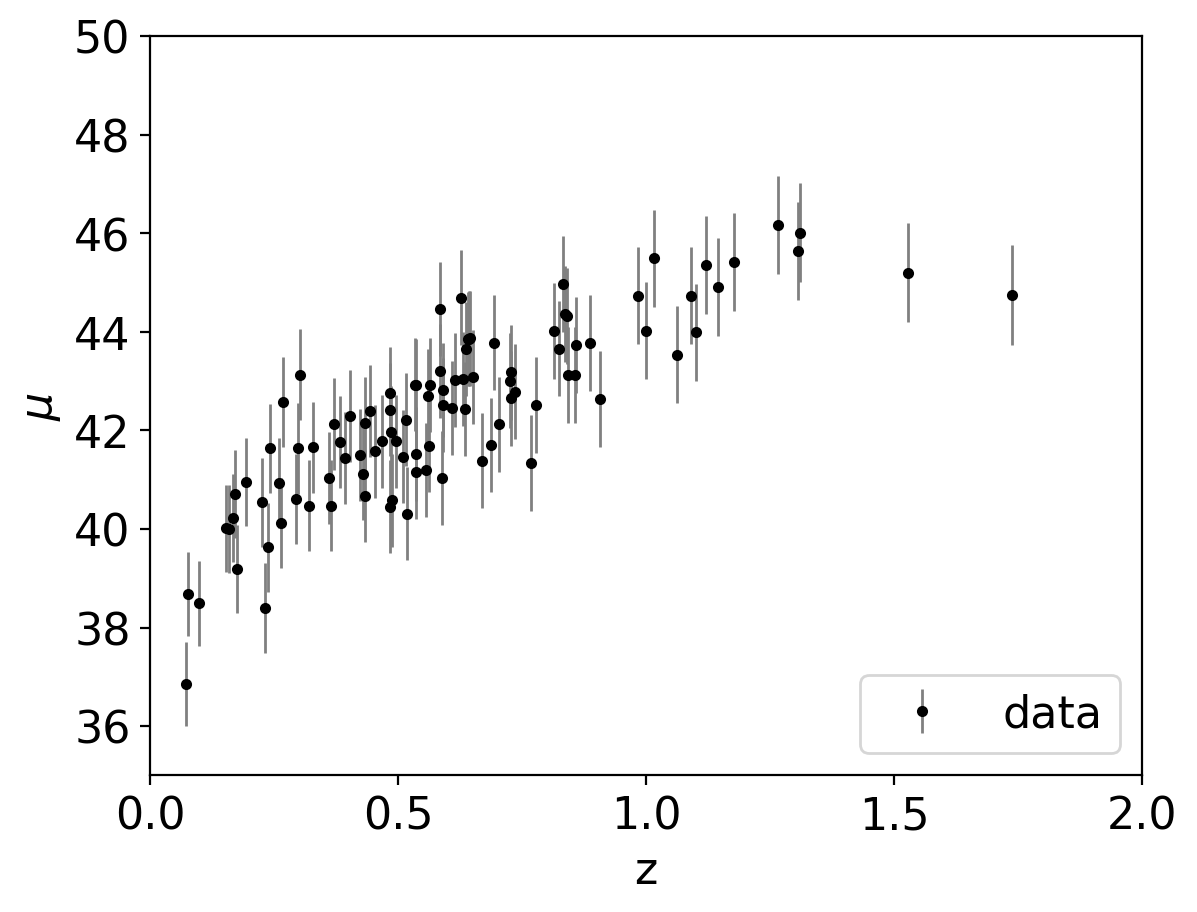

In [2]:
from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

# Part 1

## Linear regression

In [3]:
z = z_sample[:,np.newaxis]
#mu = mu_sample[:,np.newaxis]

model = LinearRegression()
model.fit(z, mu_sample, dmu)

LinearRegression()

In [4]:
X = np.arange(0,2,0.01)[:,np.newaxis]
y_pred = model.predict(X)[:,np.newaxis]
X_grid = X[:,0]

H0=71
Om0=0.27
Ode0=1-Om0

cosmo = LambdaCDM(H0, Om0=Om0, Ode0=Ode0)
mu_true = cosmo.distmod(X_grid)
#try to plot residuals

/home/olga/anaconda3/lib/python3.9/site-packages/astropy/cosmology/flrw/base.py:1284: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


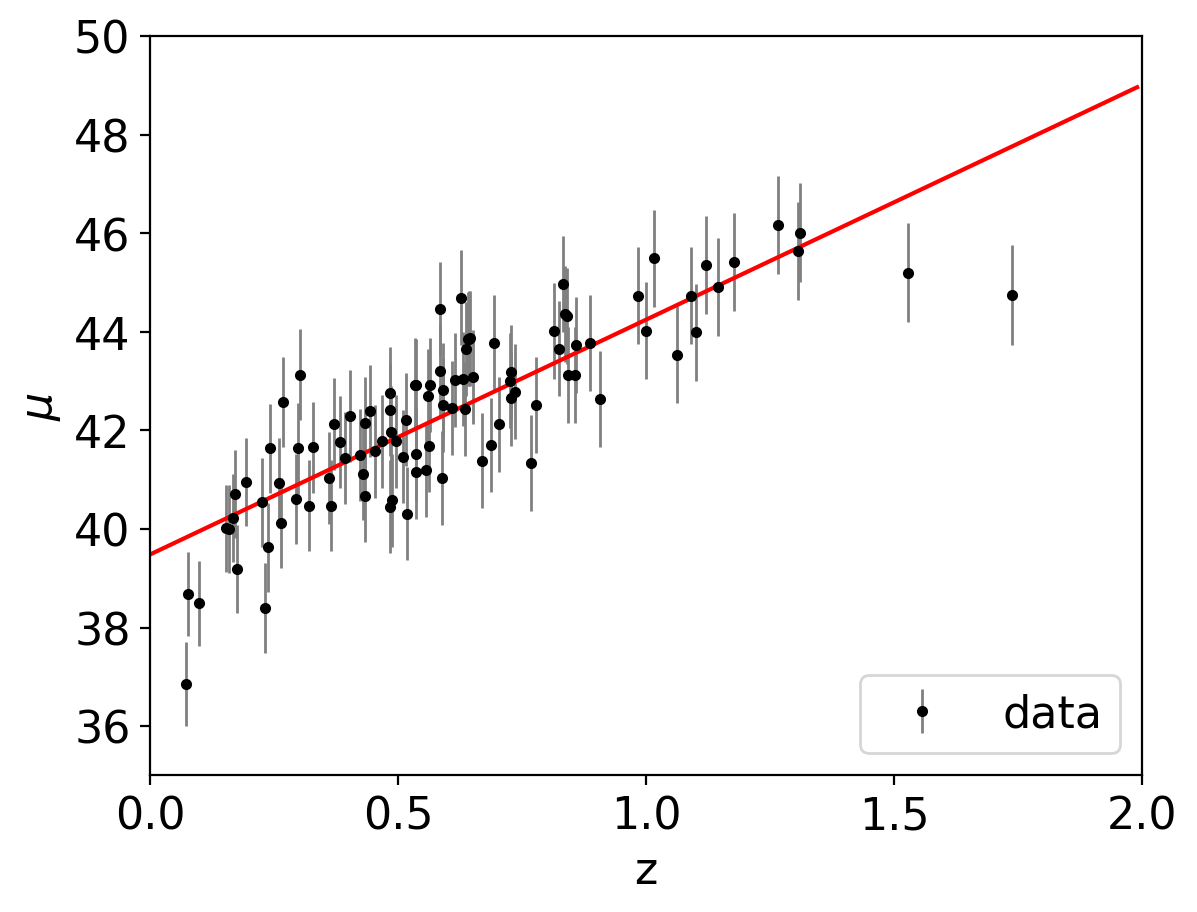

In [5]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.plot(X_grid, y_pred,'r')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

## Polynomial regression

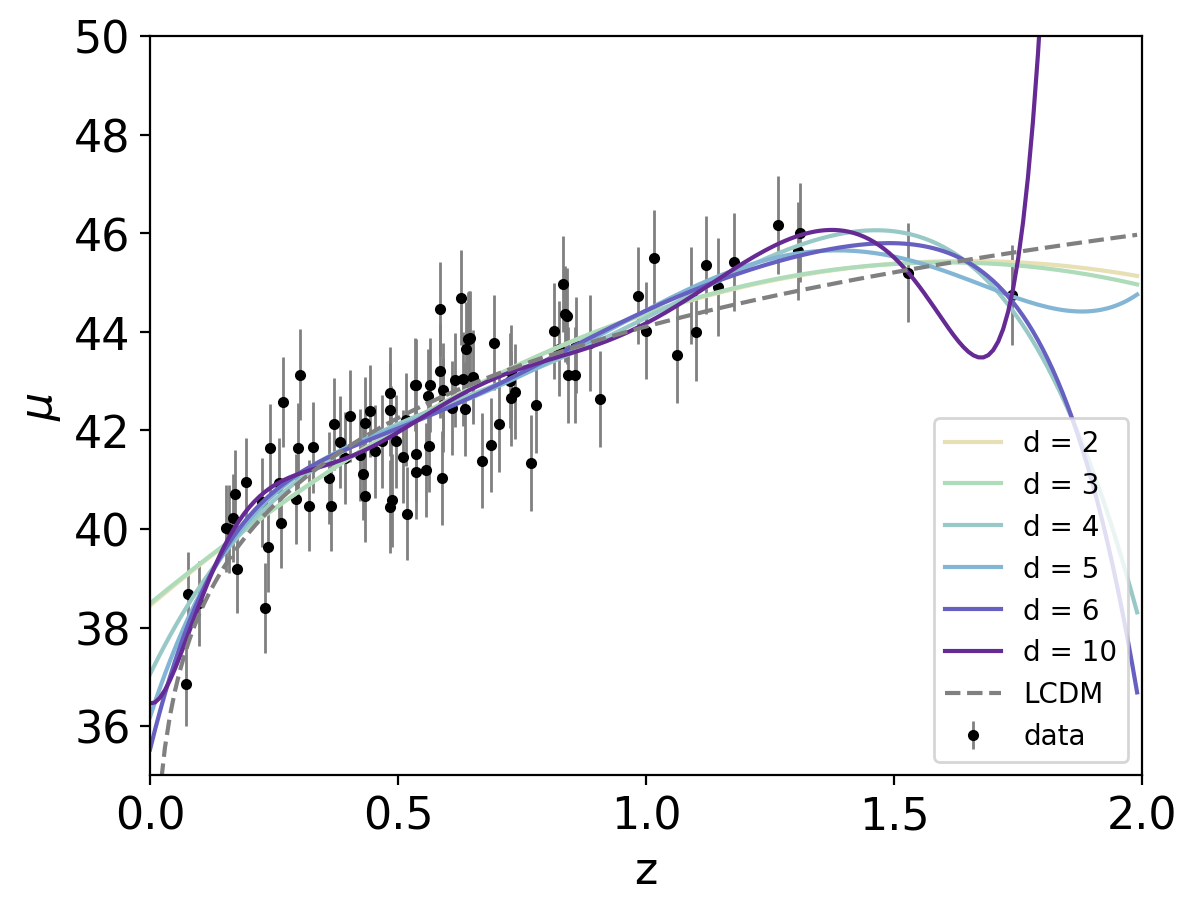

In [6]:
degree = [2,3,4,5,6,10]
colors = np.array([[231, 224, 181],[174, 220, 186],[153, 201, 199],[131, 181, 212], [102, 96, 192],[102, 42, 148]])/255.5

for d,c in zip(degree,colors):
    model1 = np.polyfit(z_sample, mu_sample, d)
    y_fit1 = np.polyval(model1, X_grid)
    plt.plot(X_grid, y_fit1,color=c, label='d = 'f'{d}')

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=0)
plt.plot(X_grid, mu_true, c='gray', ls='--',label='LCDM')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right',fontsize=10)
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Under-over fitting
Clearly the line and 2$^\text{nd}$, 3$^\text{rd}$ degree polynomial are underfitting as long as 10$^\text{th}$ is clearly overfitting. For 4$^\text{th}$, 5$^\text{th}$ and 6$^\text{th}$ it isn't clear if one of them may be the best (maybe 4$^\text{th}$ or 6$^\text{th}$?) and which one are under-over fitting (maybe  5$^\text{th}$?).

I would choose 4$^\text{th}$ degree polynomial

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
X_train, X_val, Y_train, y_val, Y_err_train, dy_val = train_test_split(z, mu_sample, dmu, test_size=0.3, random_state=42)
print(X_train.shape, Y_train.shape, Y_err_train.shape)

(70, 1) (70,) (70,)


In [9]:
def error(X,y,classifier):
    return np.sqrt( np.sum(( y - classifier.predict(X) )**2) / len(X) )

Best 4 0.8095703348999902


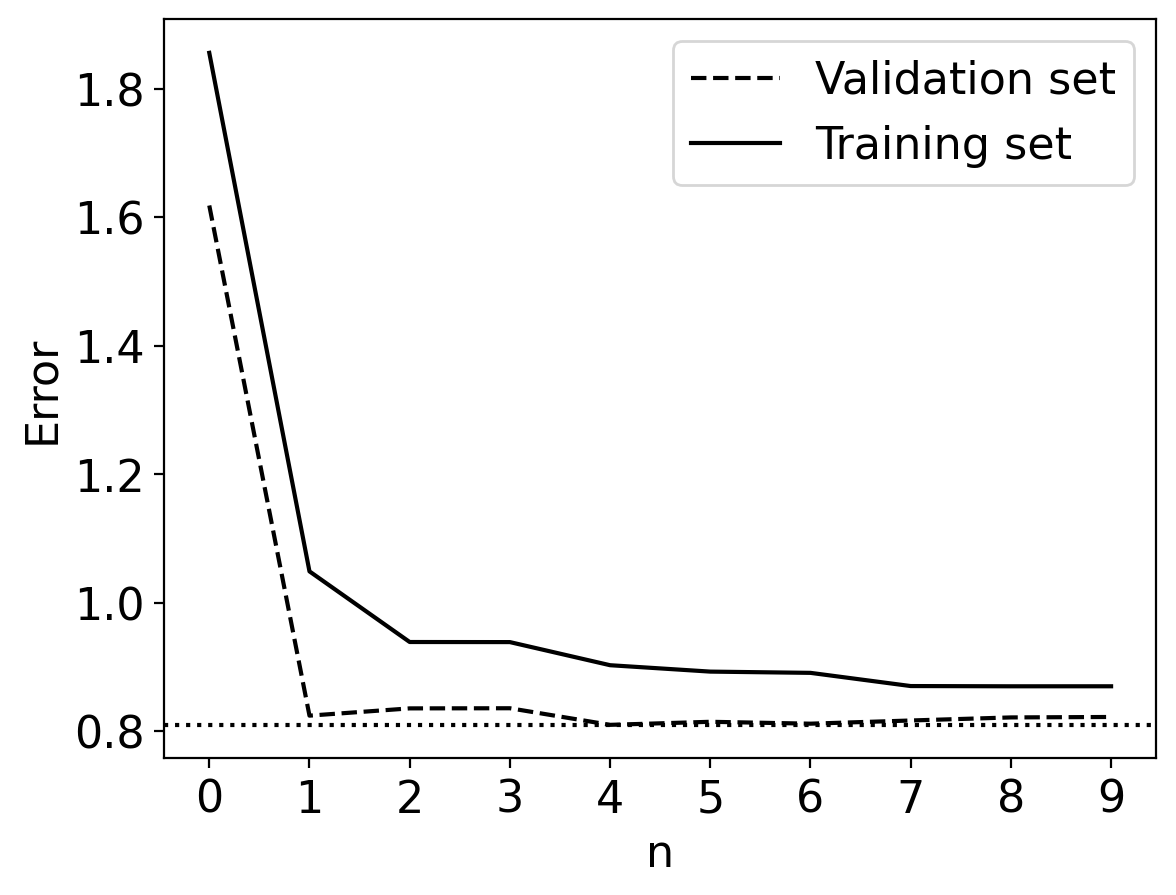

In [10]:
d = np.arange(0, 10)
etrain, etest= [], []

for n in d:
    classifier = astroML.linear_model.PolynomialRegression(n)
    classifier.fit(X_train, Y_train, Y_err_train)
    error_train = error(X_train,Y_train,classifier)
    error_validation  = error(X_val, y_val, classifier)
    etrain.append(error_train)
    etest.append(error_validation)

plt.plot(d, etest, '--k', label='Validation set')
plt.plot(d, etrain, 'k', label='Training set')
plt.axhline(etest[np.argmin(etest)], c='k',ls=':')
plt.xlabel('n')
plt.ylabel('Error')
plt.xticks(np.arange(min(d), max(d)+1, 1.0))
plt.legend()

best_deg = d[np.argmin(etest)]
print("Best", best_deg, min(etest))

### Model d=4

The best model is the 4$^\text{th}$ degree polynomial $\longrightarrow$ can we compute best parameters? [Part 2-GPR](#Part-2)

In [11]:
#definitive model
classifier = astroML.linear_model.PolynomialRegression(best_deg)

#old fit with only training set
classifier.fit(X_train, Y_train, Y_err_train)
mu_pred_train = classifier.predict(X_grid[:,np.newaxis])

#fit on all dataset
fit_all = classifier.fit(z, mu_sample, dmu)
mu_pred = classifier.predict(X_grid[:,np.newaxis])

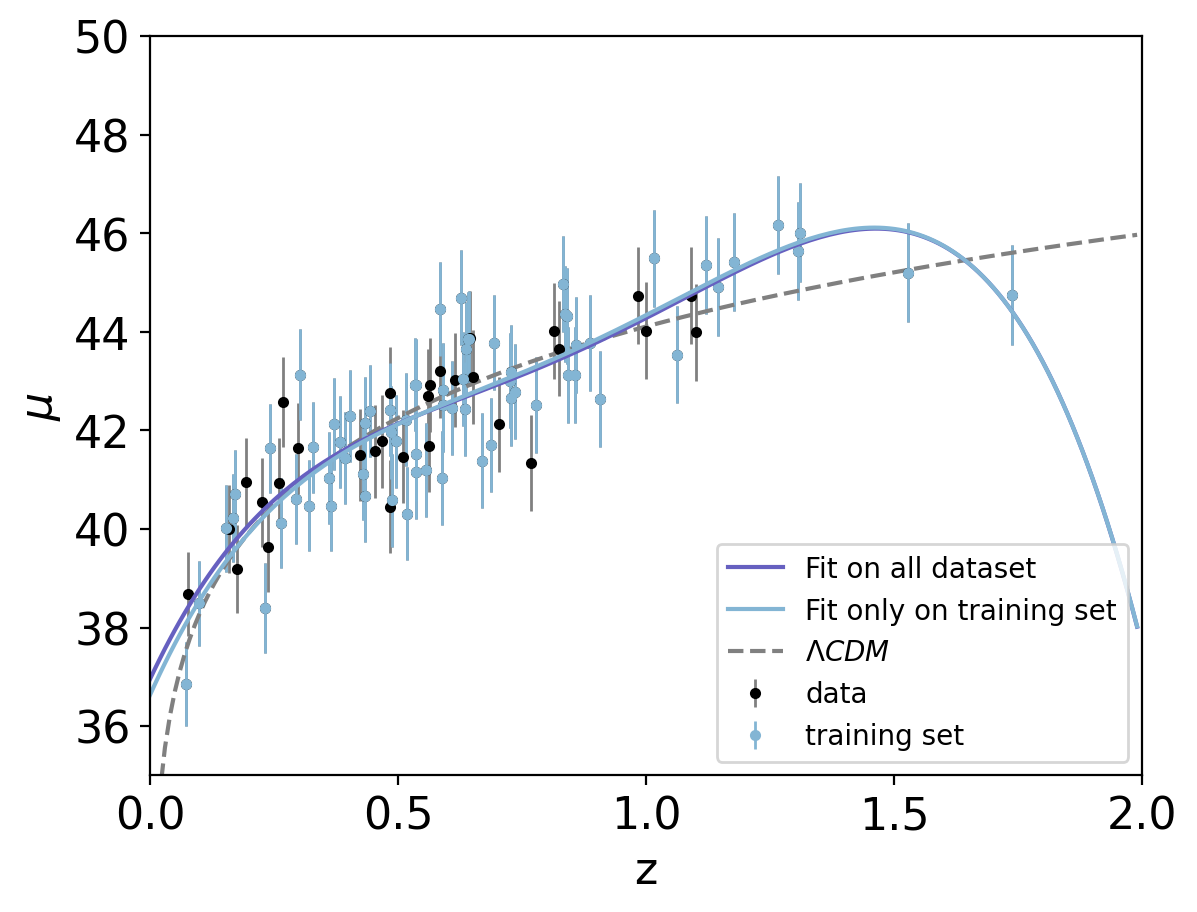

In [12]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=0)
plt.plot(X_grid, mu_pred, c=colors[4], label='Fit on all dataset')

plt.errorbar(X_train, Y_train, Y_err_train, fmt='.', mfc=colors[3], ecolor=colors[3], mec=colors[3], 
             lw=1,label='training set', zorder=0)
plt.plot(X_grid, mu_pred_train, c=colors[3], label='Fit only on training set')

plt.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$',zorder=0)

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right',fontsize=10)
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### what if..
What if now I split my dataset paying attention to exclude the last two points from the training set?

In [13]:
x_train1, y_train1, err_train1 = z[:55], mu_sample[:55], dmu[:55]
x_val1, y_val1, err_val1 = z[55:], mu_sample[55:], dmu[55:]

Best 4 1.0362194065303283


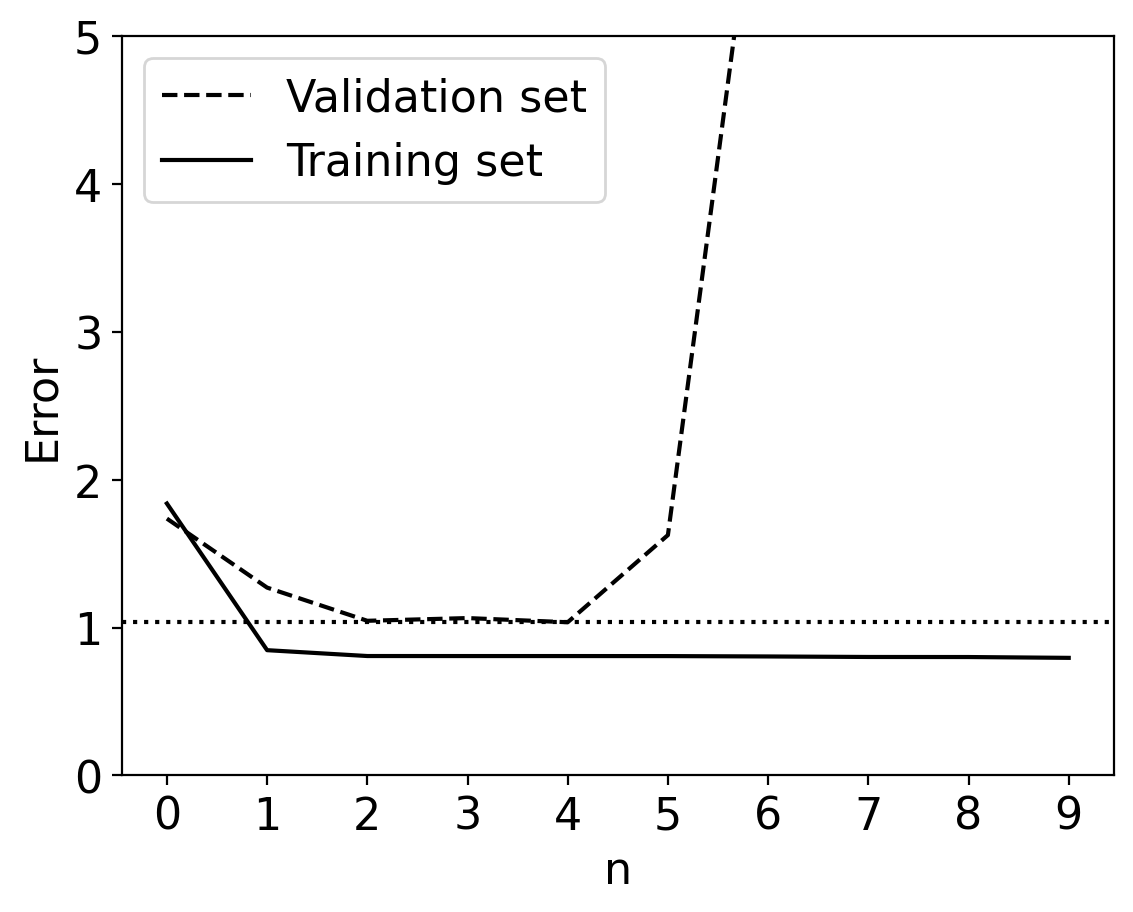

In [14]:
etrain, etest= [], []

for n in d:
    classifier = astroML.linear_model.PolynomialRegression(n)
    classifier.fit(x_train1, y_train1, err_train1)
    error_train = error(x_train1, y_train1,classifier)
    error_validation  = error(x_val1, y_val1, classifier)
    etrain.append(error_train)
    etest.append(error_validation)

plt.plot(d, etest, '--k', label='Validation set')
plt.plot(d, etrain, 'k', label='Training set')
plt.axhline(etest[np.argmin(etest)], c='k',ls=':')

plt.ylim(0,5)
plt.xlabel('n')
plt.ylabel('Error')
plt.legend()
plt.xticks(np.arange(min(d), max(d)+1, 1.0))

print("Best", d[np.argmin(etest)], min(etest))

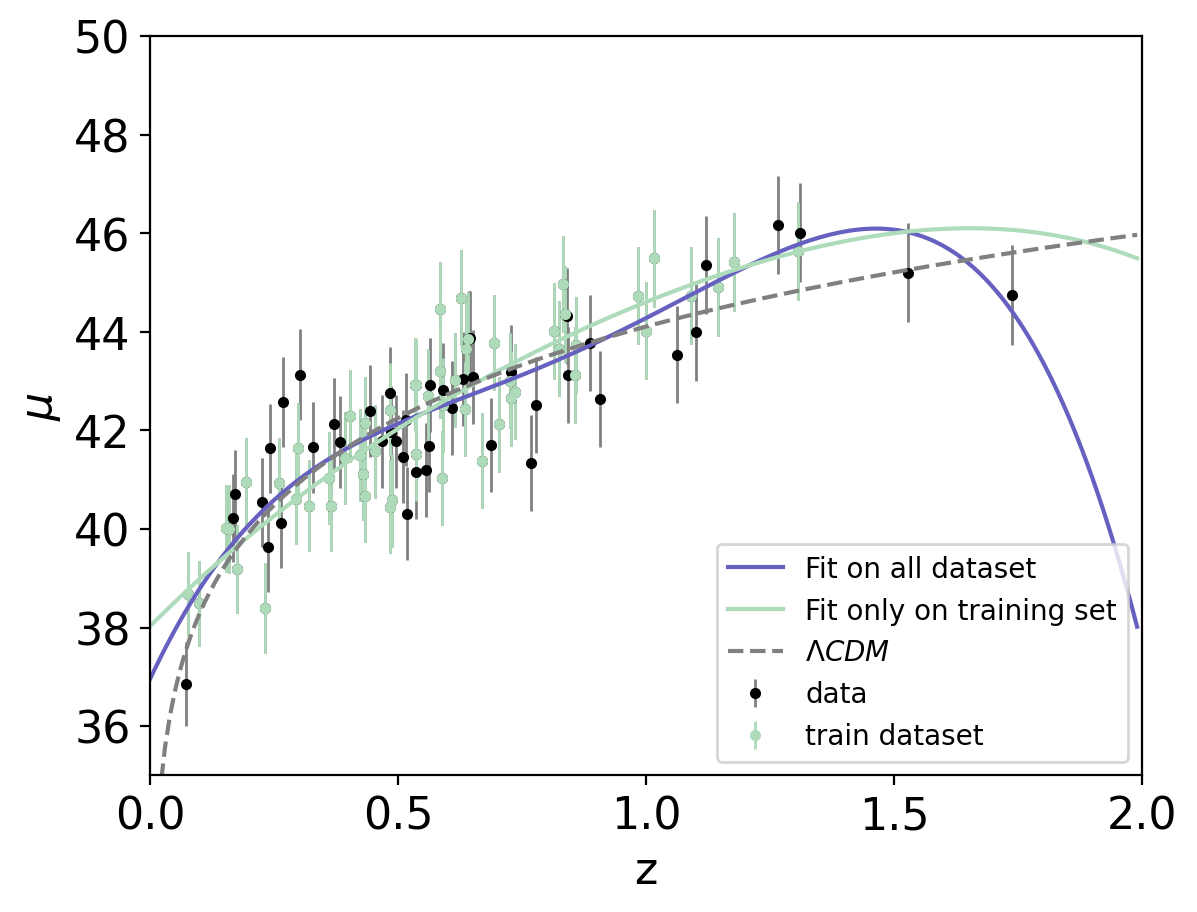

In [15]:
#definitive model
classifier = astroML.linear_model.PolynomialRegression(best_deg)

#old fit with only training set
classifier.fit(x_train1, y_train1, err_train1)
mu_pred_train = classifier.predict(X_grid[:,np.newaxis])

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=0)
plt.plot(X_grid, mu_pred, c=colors[4], label='Fit on all dataset')

plt.errorbar(x_train1, y_train1, err_train1, fmt='.', mfc=colors[1], ecolor=colors[1], 
             mec=colors[1], lw=1,label='train dataset', zorder=0)
plt.plot(X_grid, mu_pred_train, c=colors[1], label='Fit only on training set')

plt.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right',fontsize=10)
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

# Part 2

## Gaussian Process Regression GPR

https://george.readthedocs.io/en/latest/tutorials/first/

In [16]:
kernel = kernels.RBF(10, (1e-2, 1e2))*1.0
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dmu) ** 2, random_state=0, normalize_y=False)
gp.fit(z, mu_sample)
f, f_err = gp.predict(X, return_std=True)
print("best-fit theta =", gp.kernel_.theta)

best-fit theta = [1.36058232 6.84740541]


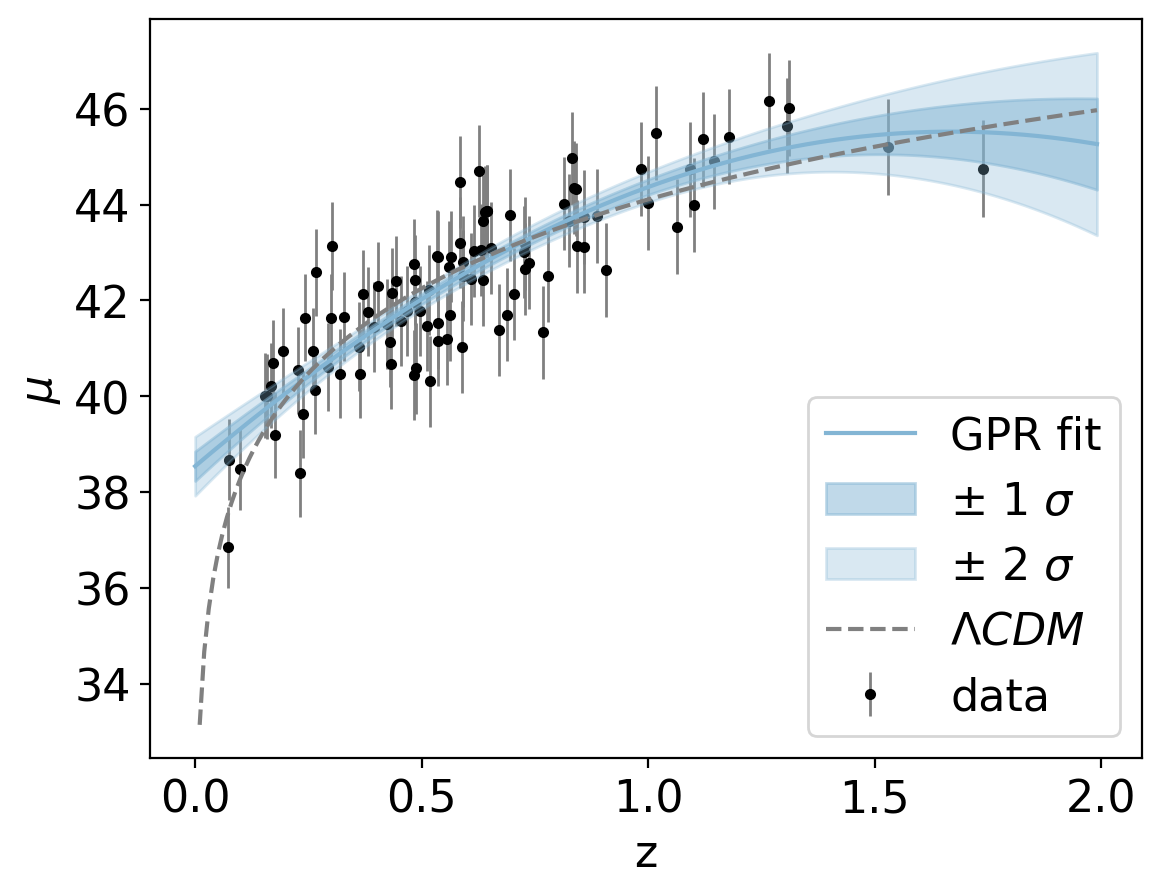

In [17]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=0)

plt.plot(X_grid, f, '-', color=colors[3], label='GPR fit')
plt.fill_between(X_grid, f - f_err, f + f_err, color=colors[3], alpha=0.5, label='$\pm$ 1 $\sigma$')
plt.fill_between(X_grid, f - 2 * f_err, f + 2 * f_err, color=colors[3], alpha=0.3, label='$\pm$ 2 $\sigma$')

plt.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend()
plt.show()

### MCMC

In [18]:
#not working
def integrand(redshift):
    return 1/( np.sqrt(Om0*(1 + redshift**3) + Ode0 ) )

#not working
def fit(redshift1,integral1):
    c = 3e8
    d = 3.086e+16
    return 5*np.log( (c/H0/d)*(1 + redshift1) * integral1 )

def dist(redshift,H0, Om0):
    cosmo_z = LambdaCDM(H0, Om0=Om0, Ode0=(1-Om0))
    return cosmo_z.distmod(redshift).value

#define the likelihood
def like(prob, red, mu_d, err_mu=1):
    H0, Om0 = prob
    return np.prod(np.exp(-1/2*(mu_d - dist(red,H0, Om0)/err_mu)**2)/(np.sqrt(2*np.pi*err_mu**2)))


#define the prior
def prior(prob):
    H0, Om0 = prob
    if 50 < H0 < 100 and 0.1 < Om0 < 1:
        return 1
    return 0

#define posterior
def logposterior(prob, red, mu_d, err_mu):
    return np.log(like(prob, red, mu_d, err_mu)*prior(prob))

#TRY WITH THE LOG AND THEN SUM!
def Logprior(theta):
    H0, Om0 = theta
    if 50 < H0 < 100 and 0.1 < Om0 < 1:
        return 0.0
    return -np.inf

def LogLikelihood(theta):
    H0, Om0 = theta
    if Om0 < 0:
        return -np.inf
    
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu_sample - dist(z_sample,H0, Om0)) / dmu)**2)

                   
def LogPosterior(theta):
    return LogLikelihood(theta) + Logprior(theta)

In [19]:
ndim = 2  # number of parameters in the model
nwalkers = 20 # number of MCMC walkers
burn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take **for each walker**

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))*1e-1+np.array([80, 0.5])

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, LogPosterior)
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)
flat_trace = emcee_trace.flatten()

print("done")
print(starting_guesses)

done
[[80.05488135  0.57151894]
 [80.06027634  0.55448832]
 [80.04236548  0.56458941]
 [80.04375872  0.5891773 ]
 [80.09636628  0.53834415]
 [80.0791725   0.55288949]
 [80.05680446  0.59255966]
 [80.00710361  0.50871293]
 [80.00202184  0.58326198]
 [80.07781568  0.58700121]
 [80.09786183  0.57991586]
 [80.04614794  0.57805292]
 [80.01182744  0.5639921 ]
 [80.01433533  0.59446689]
 [80.05218483  0.54146619]
 [80.02645556  0.57742337]
 [80.04561503  0.55684339]
 [80.00187898  0.56176355]
 [80.06120957  0.5616934 ]
 [80.09437481  0.56818203]]


In [20]:
tau = sampler.get_autocorr_time()
print(tau)

[37.74395239 37.7859907 ]


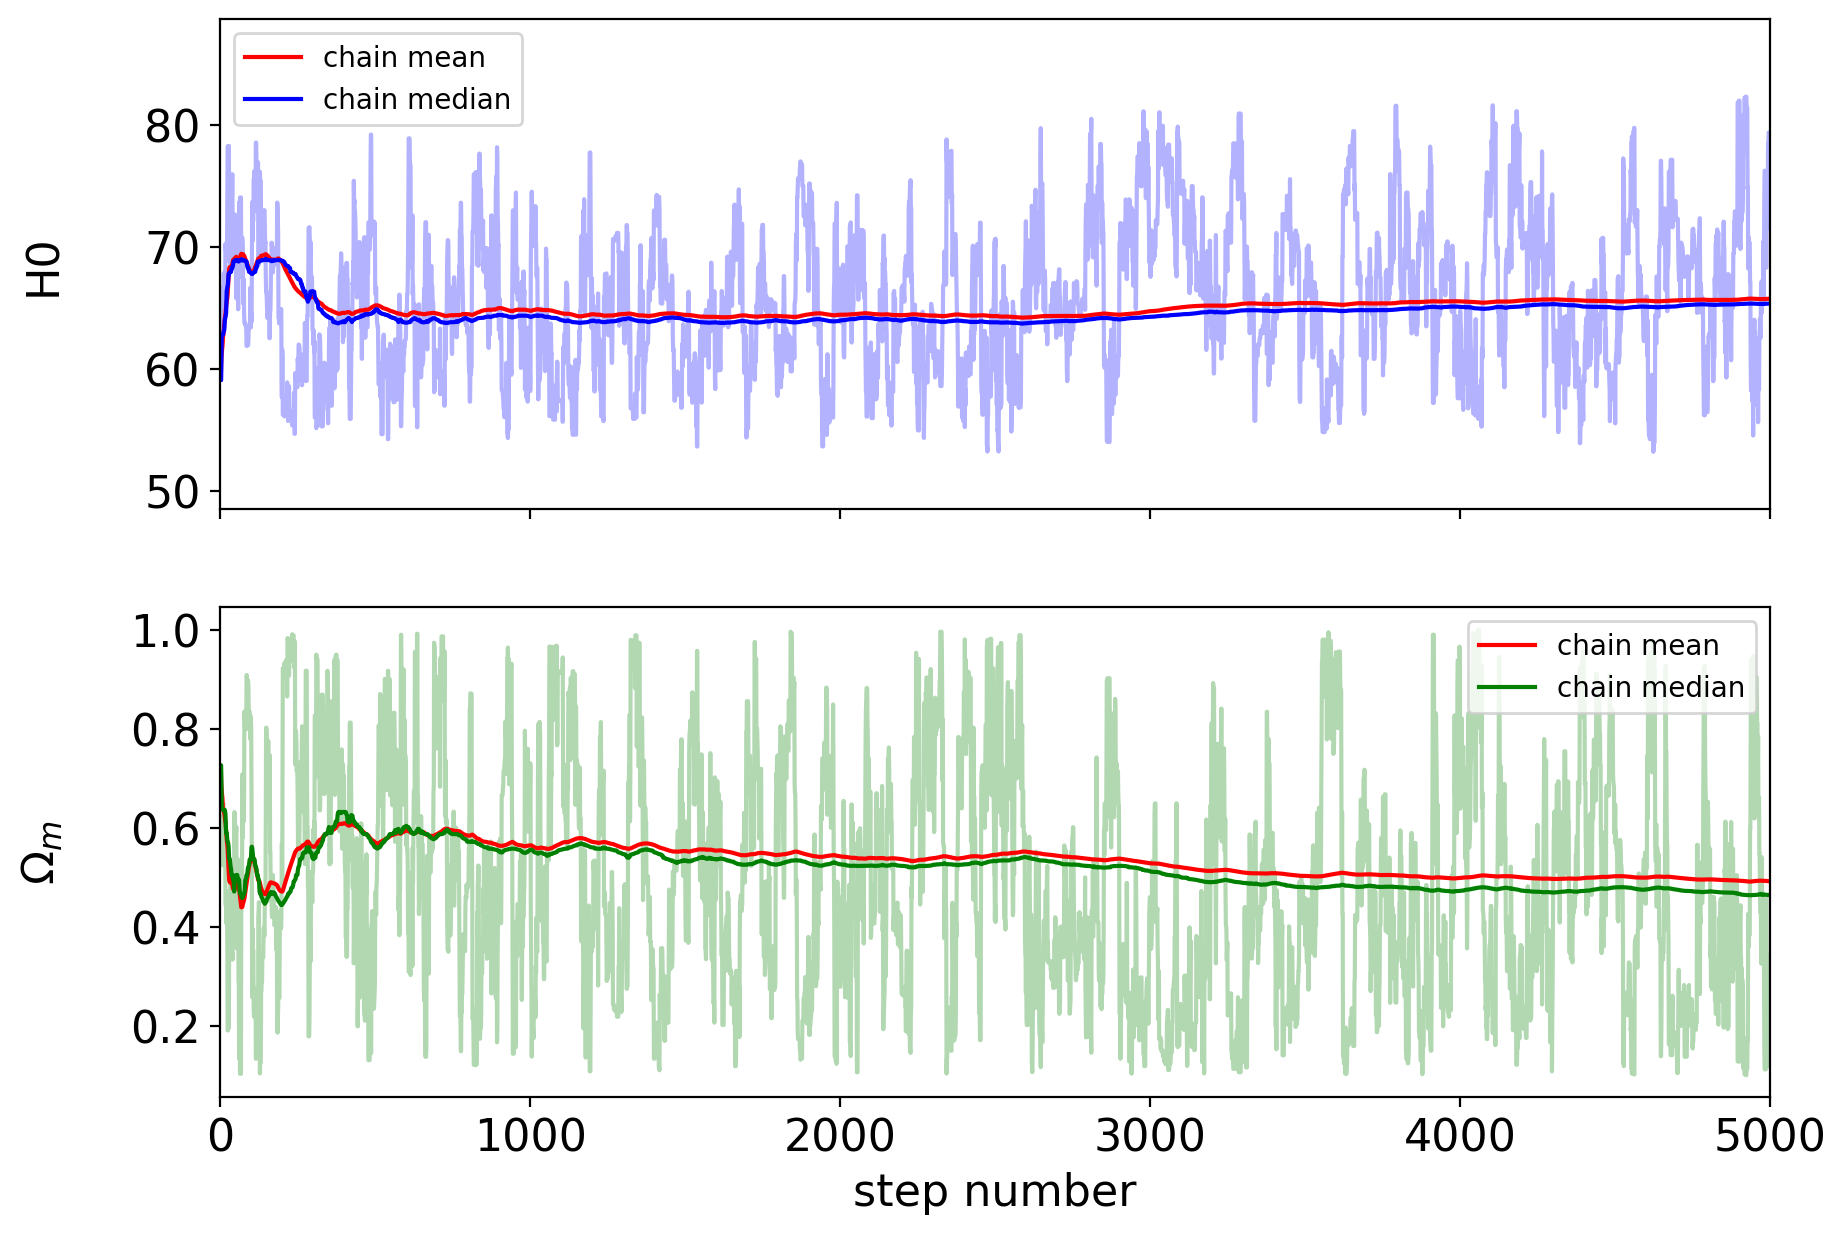

In [21]:
from matplotlib import rcParams

#rcParams["savefig.dpi"] = 100
#rcParams["figure.dpi"] = 300
#rcParams["font.size"] = 10

#plot 
xgrid1 = np.linspace(1, nsteps, nsteps)
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
mc_colors = ["blue", "green"]
labels = ["H0", r"$\Omega_m$"]
meanC = []
median = []

for i in range(ndim):
                
    # plot running mean: 
    meanC_i = [np.mean(emcee_trace[:int(N),i]) for N in xgrid1]
    medianC_i = [np.median(emcee_trace[:int(N),i]) for N in xgrid1]
    meanC.append(meanC_i[nsteps-1])
    median.append(medianC_i[nsteps-1])
    
    ax = axes[i]
    ax.plot(emcee_trace[:,i], color=mc_colors[i], alpha=0.3)
    ax.plot(xgrid1, meanC_i, c='red', label='chain mean')
    ax.plot(xgrid1, medianC_i, c=mc_colors[i], label='chain median') 
    #ax.plot(xgrid, 0*xgrid + np.mean(data), c='yellow',label='data mean')
    ax.set_xlim(0, nsteps)
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.legend(fontsize=10)

axes[-1].set_xlabel("step number");

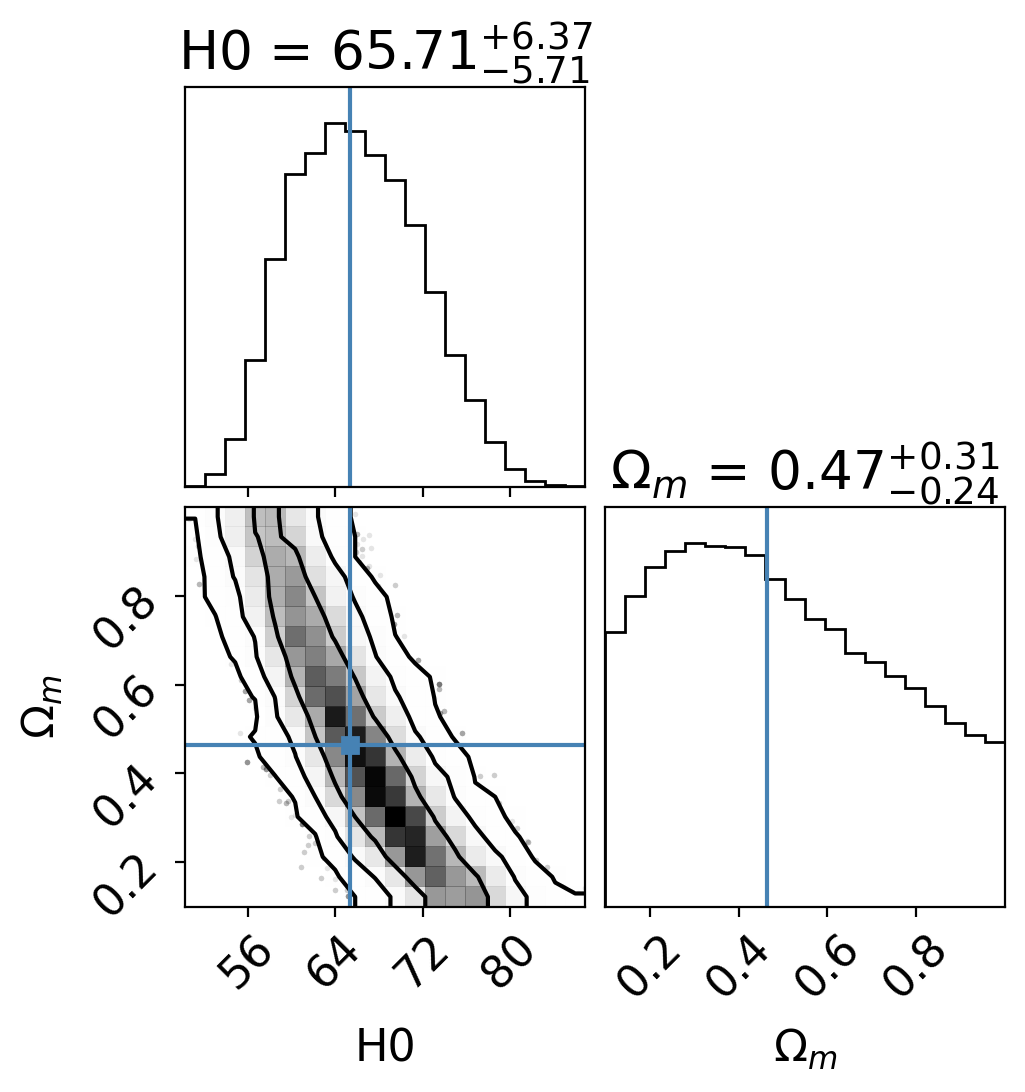

In [22]:
fig = corner.corner(
    emcee_trace, labels=labels, levels=[0.683, 0.955, 0.997], truths=median, show_titles=True) #0.5 quantile

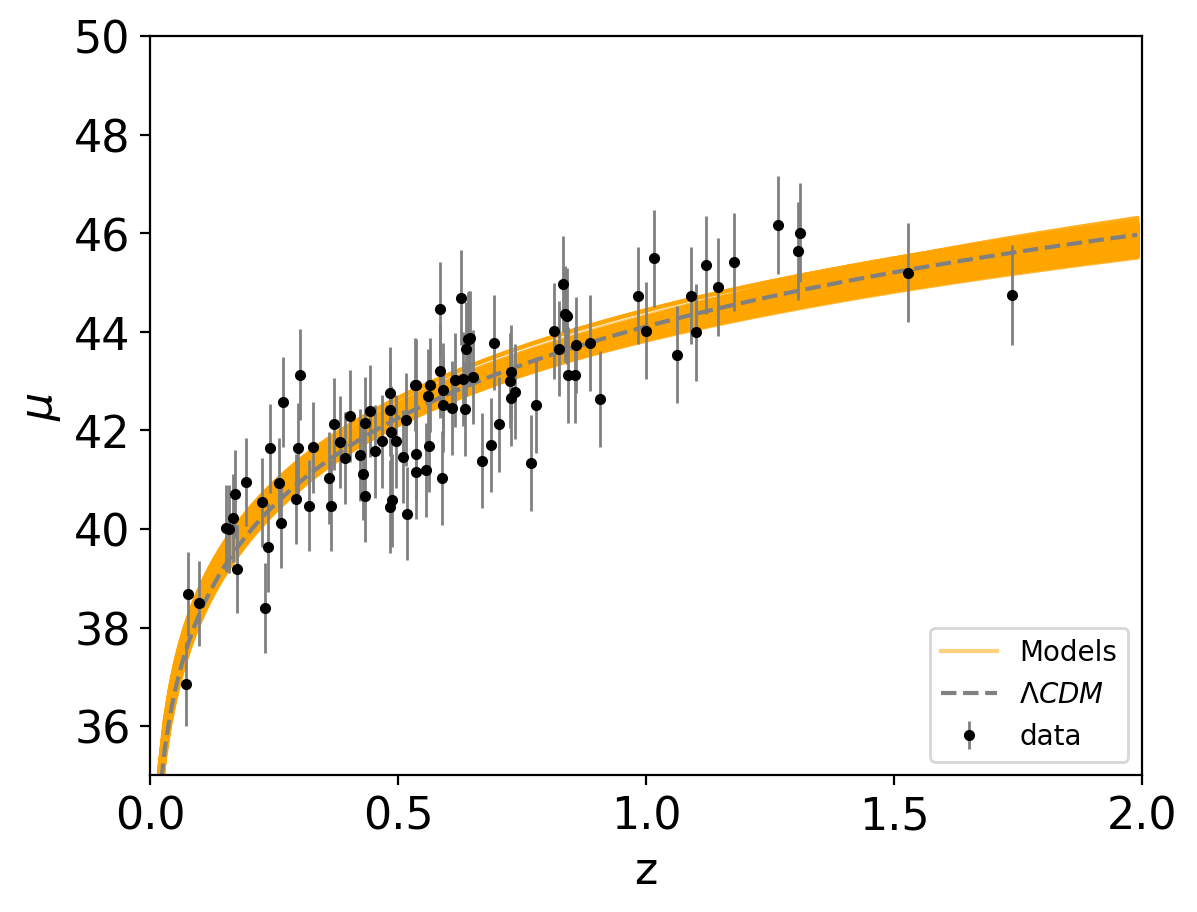

In [23]:
#plot 100 samples with the distrib of parameters found

H0_i = emcee_trace[:,0]
omegam_i = emcee_trace[:,1]
y_predictions_0 = dist(X_grid,H0_i[2000], omegam_i[2000])

for i in range(1, 500):
    y_predictions = dist(X_grid, H0_i[2000+i], omegam_i[2000+i])
    plt.plot(X_grid, y_predictions, 'orange', alpha=0.5, zorder=0)
    
plt.plot(X_grid, y_predictions_0, 'orange', alpha=0.5, label='Models', zorder=0)
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=0)
plt.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$',zorder=0)
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right',fontsize=10)
plt.xlim(0,2)
plt.ylim(35,50)
plt.show()

### Nested sampling

In [24]:
#define the prior
def dyn_prior(param):
    H0, Om0 = param
    return (stats.uniform.ppf(H0, 50, 100), stats.uniform.ppf(Om0, 0.0, 1))

#define the loglikelihood
def dyn_like(param):
    H0, Om0 = param
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu_sample - dist(z_sample,H0, Om0)) / dmu)**2)

In [25]:
ndim = 2 #dimension

# "Static" nested sampling.
sampler = dynesty.NestedSampler(dyn_like, dyn_prior, ndim, nlive=5000)
sampler.run_nested()
sresults = sampler.results

9884it [01:17, 128.11it/s, +5000 | bound: 0 | nc: 1 | ncall: 41000 | eff(%): 41.344 | loglstar:   -inf < -132.813 <    inf | logz: -135.691 +/-    nan | dlogz:  0.000 >  5.009]


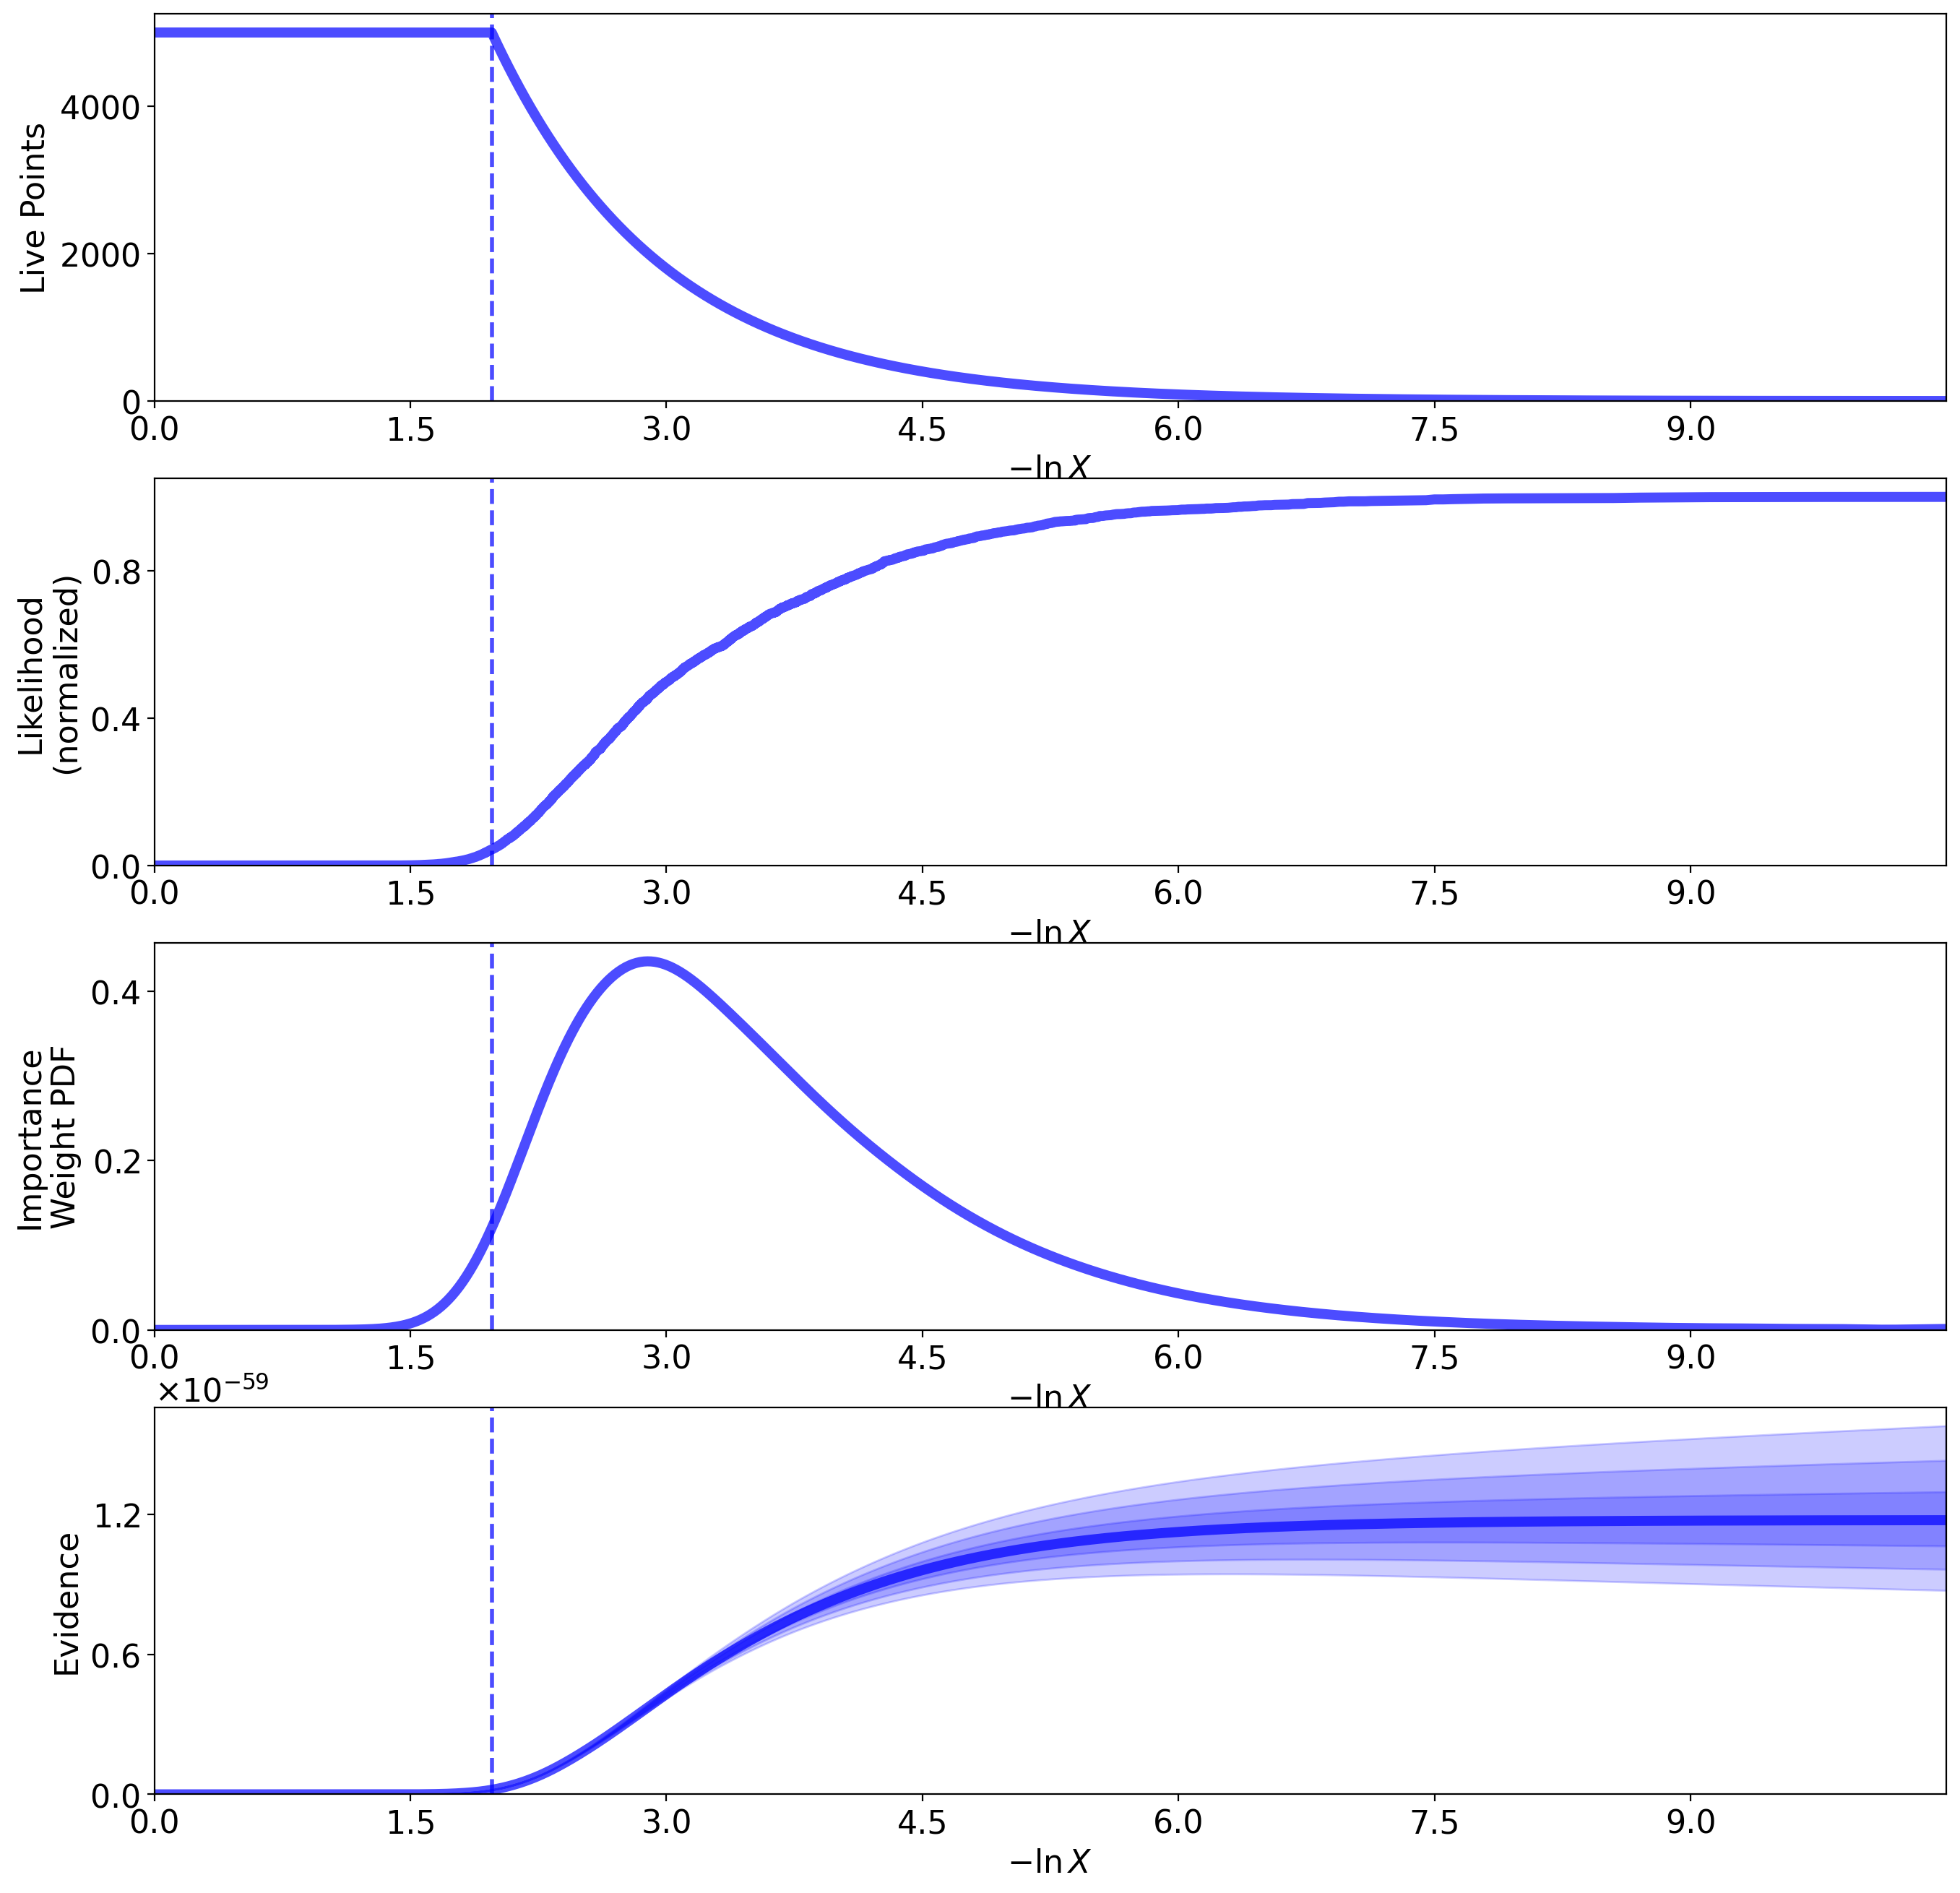

In [26]:
rfig, raxes = dyplot.runplot(sresults)

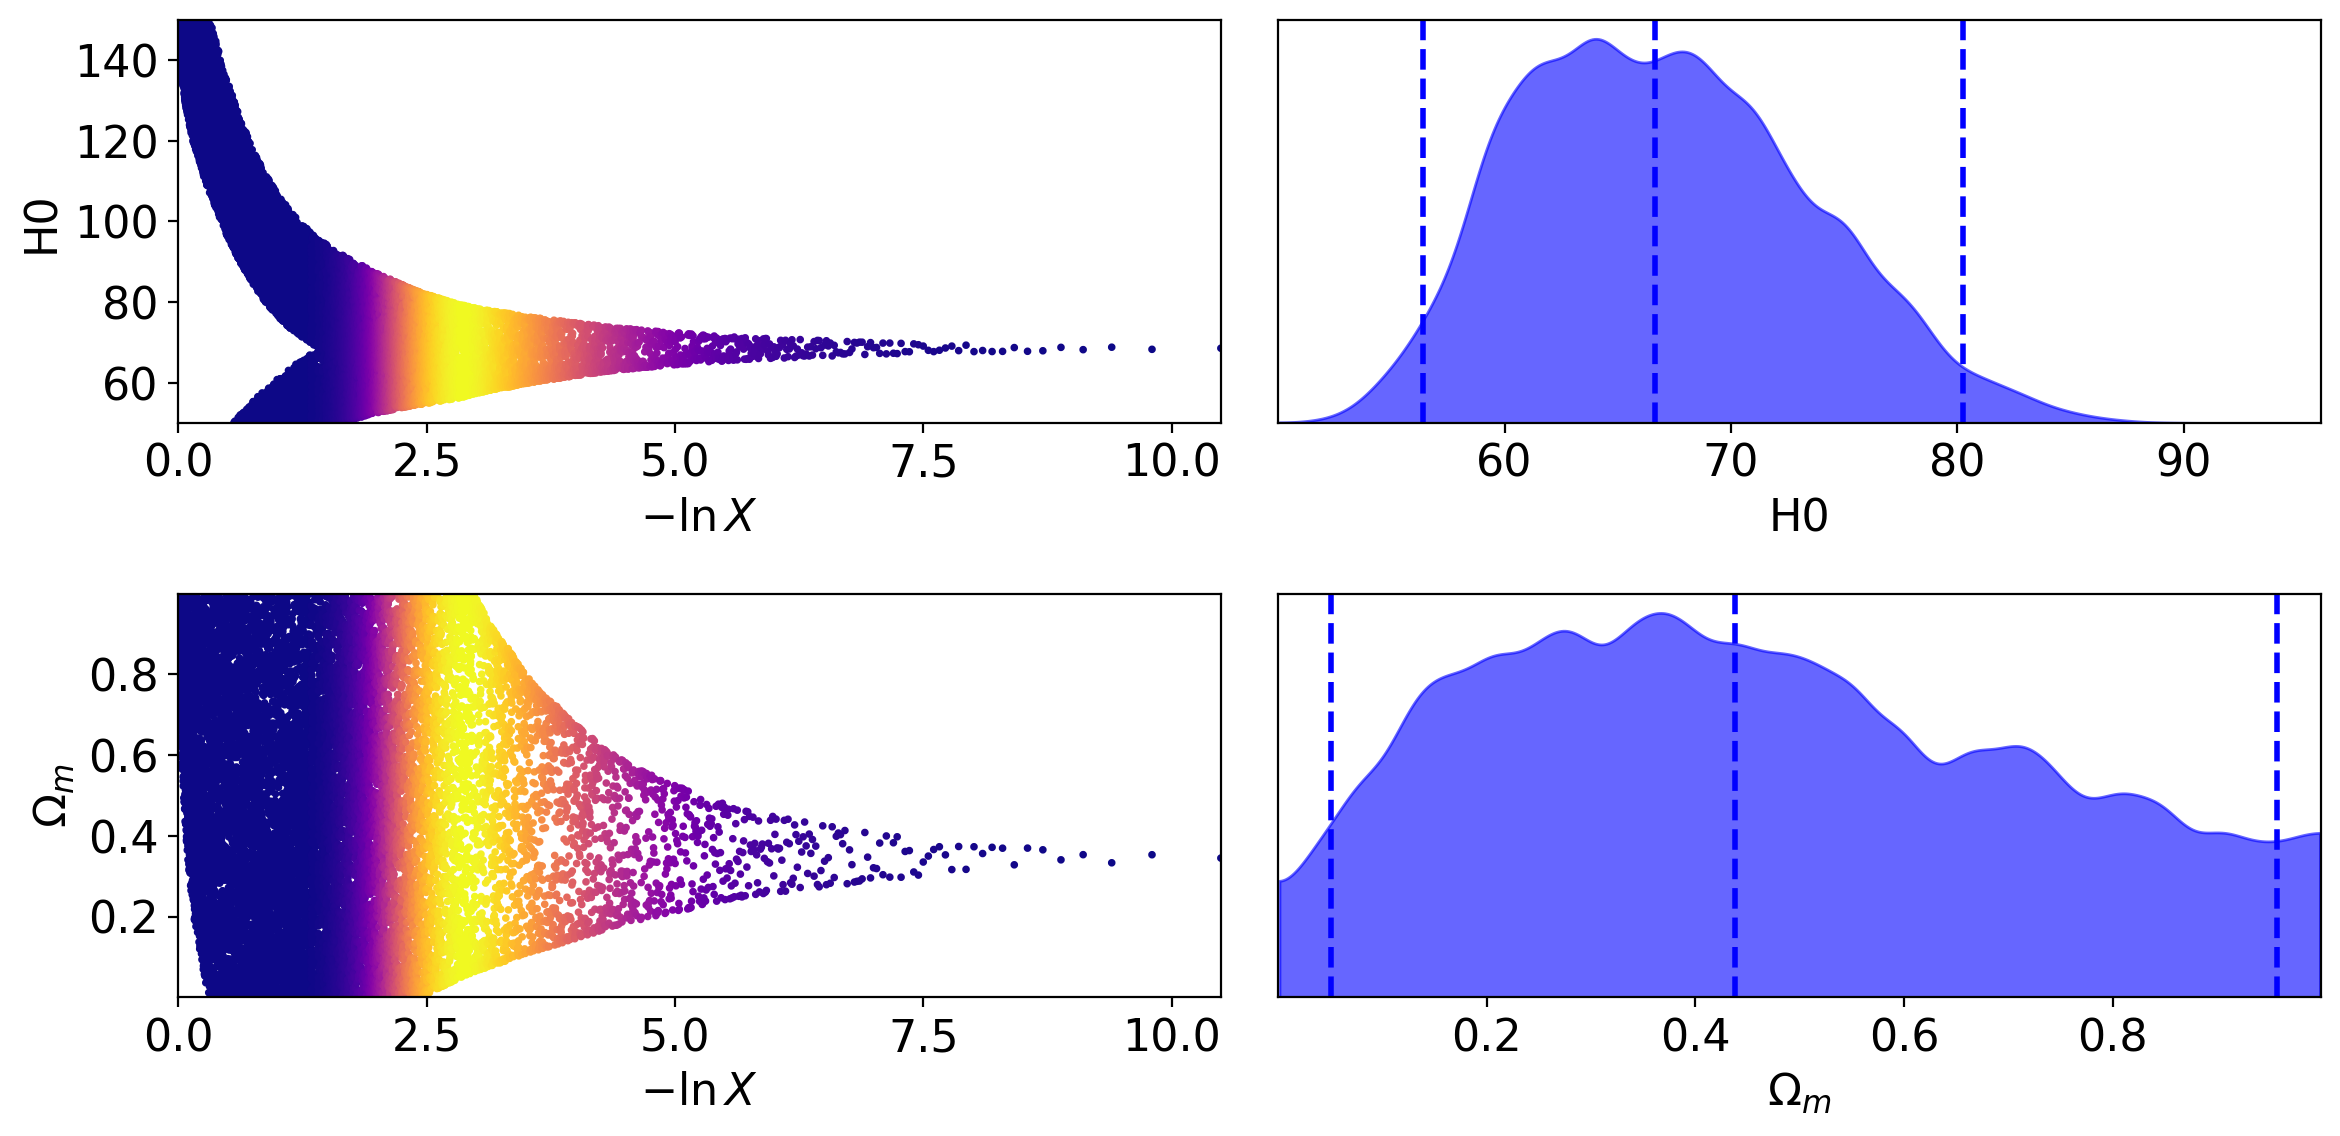

In [27]:
tfig, taxes = dyplot.traceplot(sresults, labels=labels)
tfig.tight_layout()

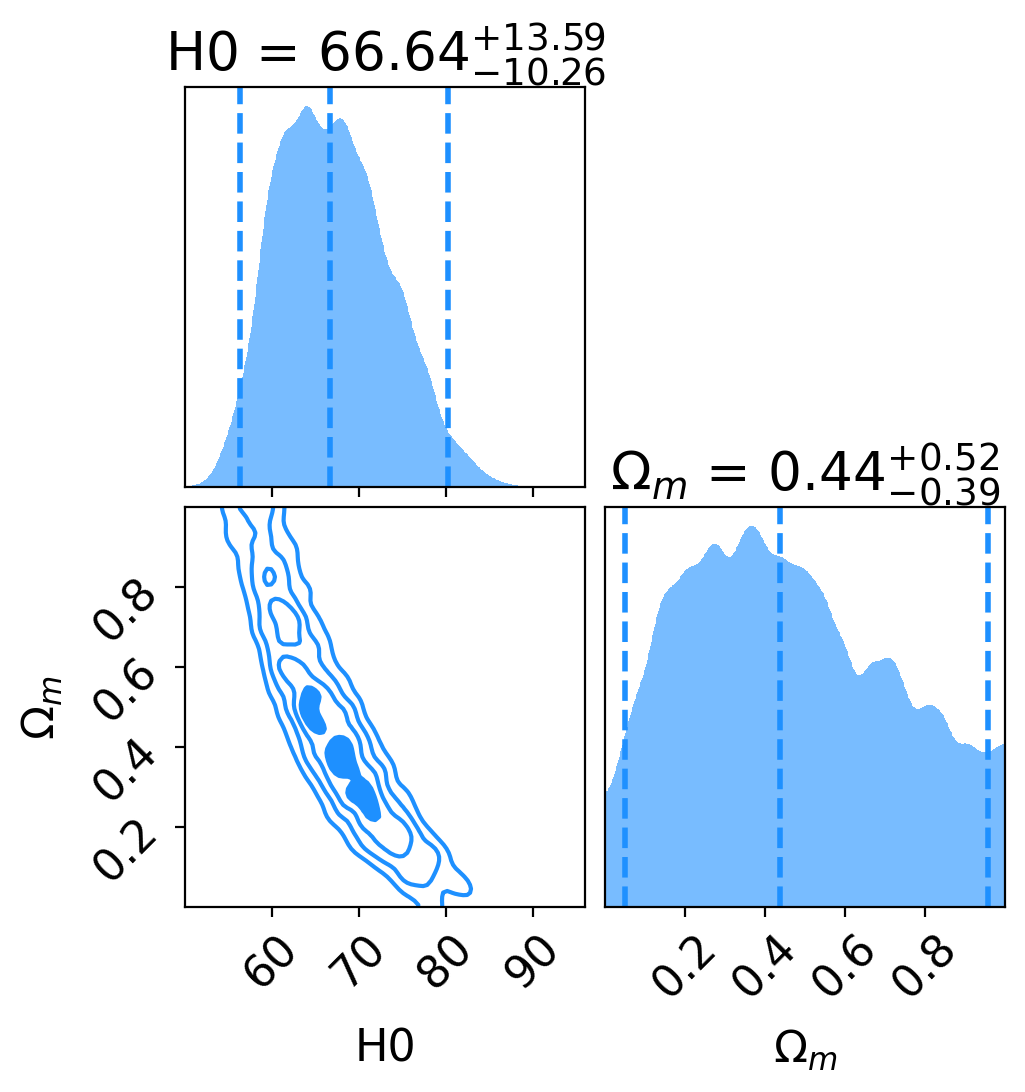

In [28]:
fg, ax = dyplot.cornerplot(sresults, color='dodgerblue', #truths=np.zeros(ndim),
                           truth_color='black', show_titles=True, labels=labels)

In [29]:
weights = np.exp(sresults['logwt'] - sresults['logz'][-1])
postsamples = resample_equal(sresults.samples, weights)

### Compagring models
How would a model without dark matter $\Omega_{\Lambda} = 0$, so that $\Omega_m$ = 1 be?

-----------
As can be seen from the Bayesian odds factor $\Omega_{\Lambda} \ne 0 \text{   vs   } \Omega_{\Lambda} = 0$  of 297 and the plot below, the favored model is the one where $\Omega_{\Lambda} \ne 0 \longrightarrow$ the $\Lambda CDM$ one

In [30]:
#define the prior
def dyn_prior_wode(H0):
    return (stats.uniform.ppf(H0, 50, 100))

#define the loglikelihood
def dyn_like_wode(param):
    H0 = float(param)
    Om0 = 1
    return - 0.5 * np.sum(np.log(2*np.pi*dmu**2) + ((mu_sample - dist(z_sample,H0, Om0)) / dmu)**2)

In [31]:
ndim = 1 #dimension

# "Static" nested sampling.
sampler1 = dynesty.NestedSampler(dyn_like_wode, dyn_prior_wode, ndim, nlive=5000)
sampler1.run_nested()
sresults1 = sampler1.results

10511it [01:12, 145.02it/s, +5000 | bound: 0 | nc: 1 | ncall: 45792 | eff(%): 38.025 | loglstar:   -inf < -133.530 <    inf | logz: -136.304 +/-    nan | dlogz:  0.000 >  5.009]


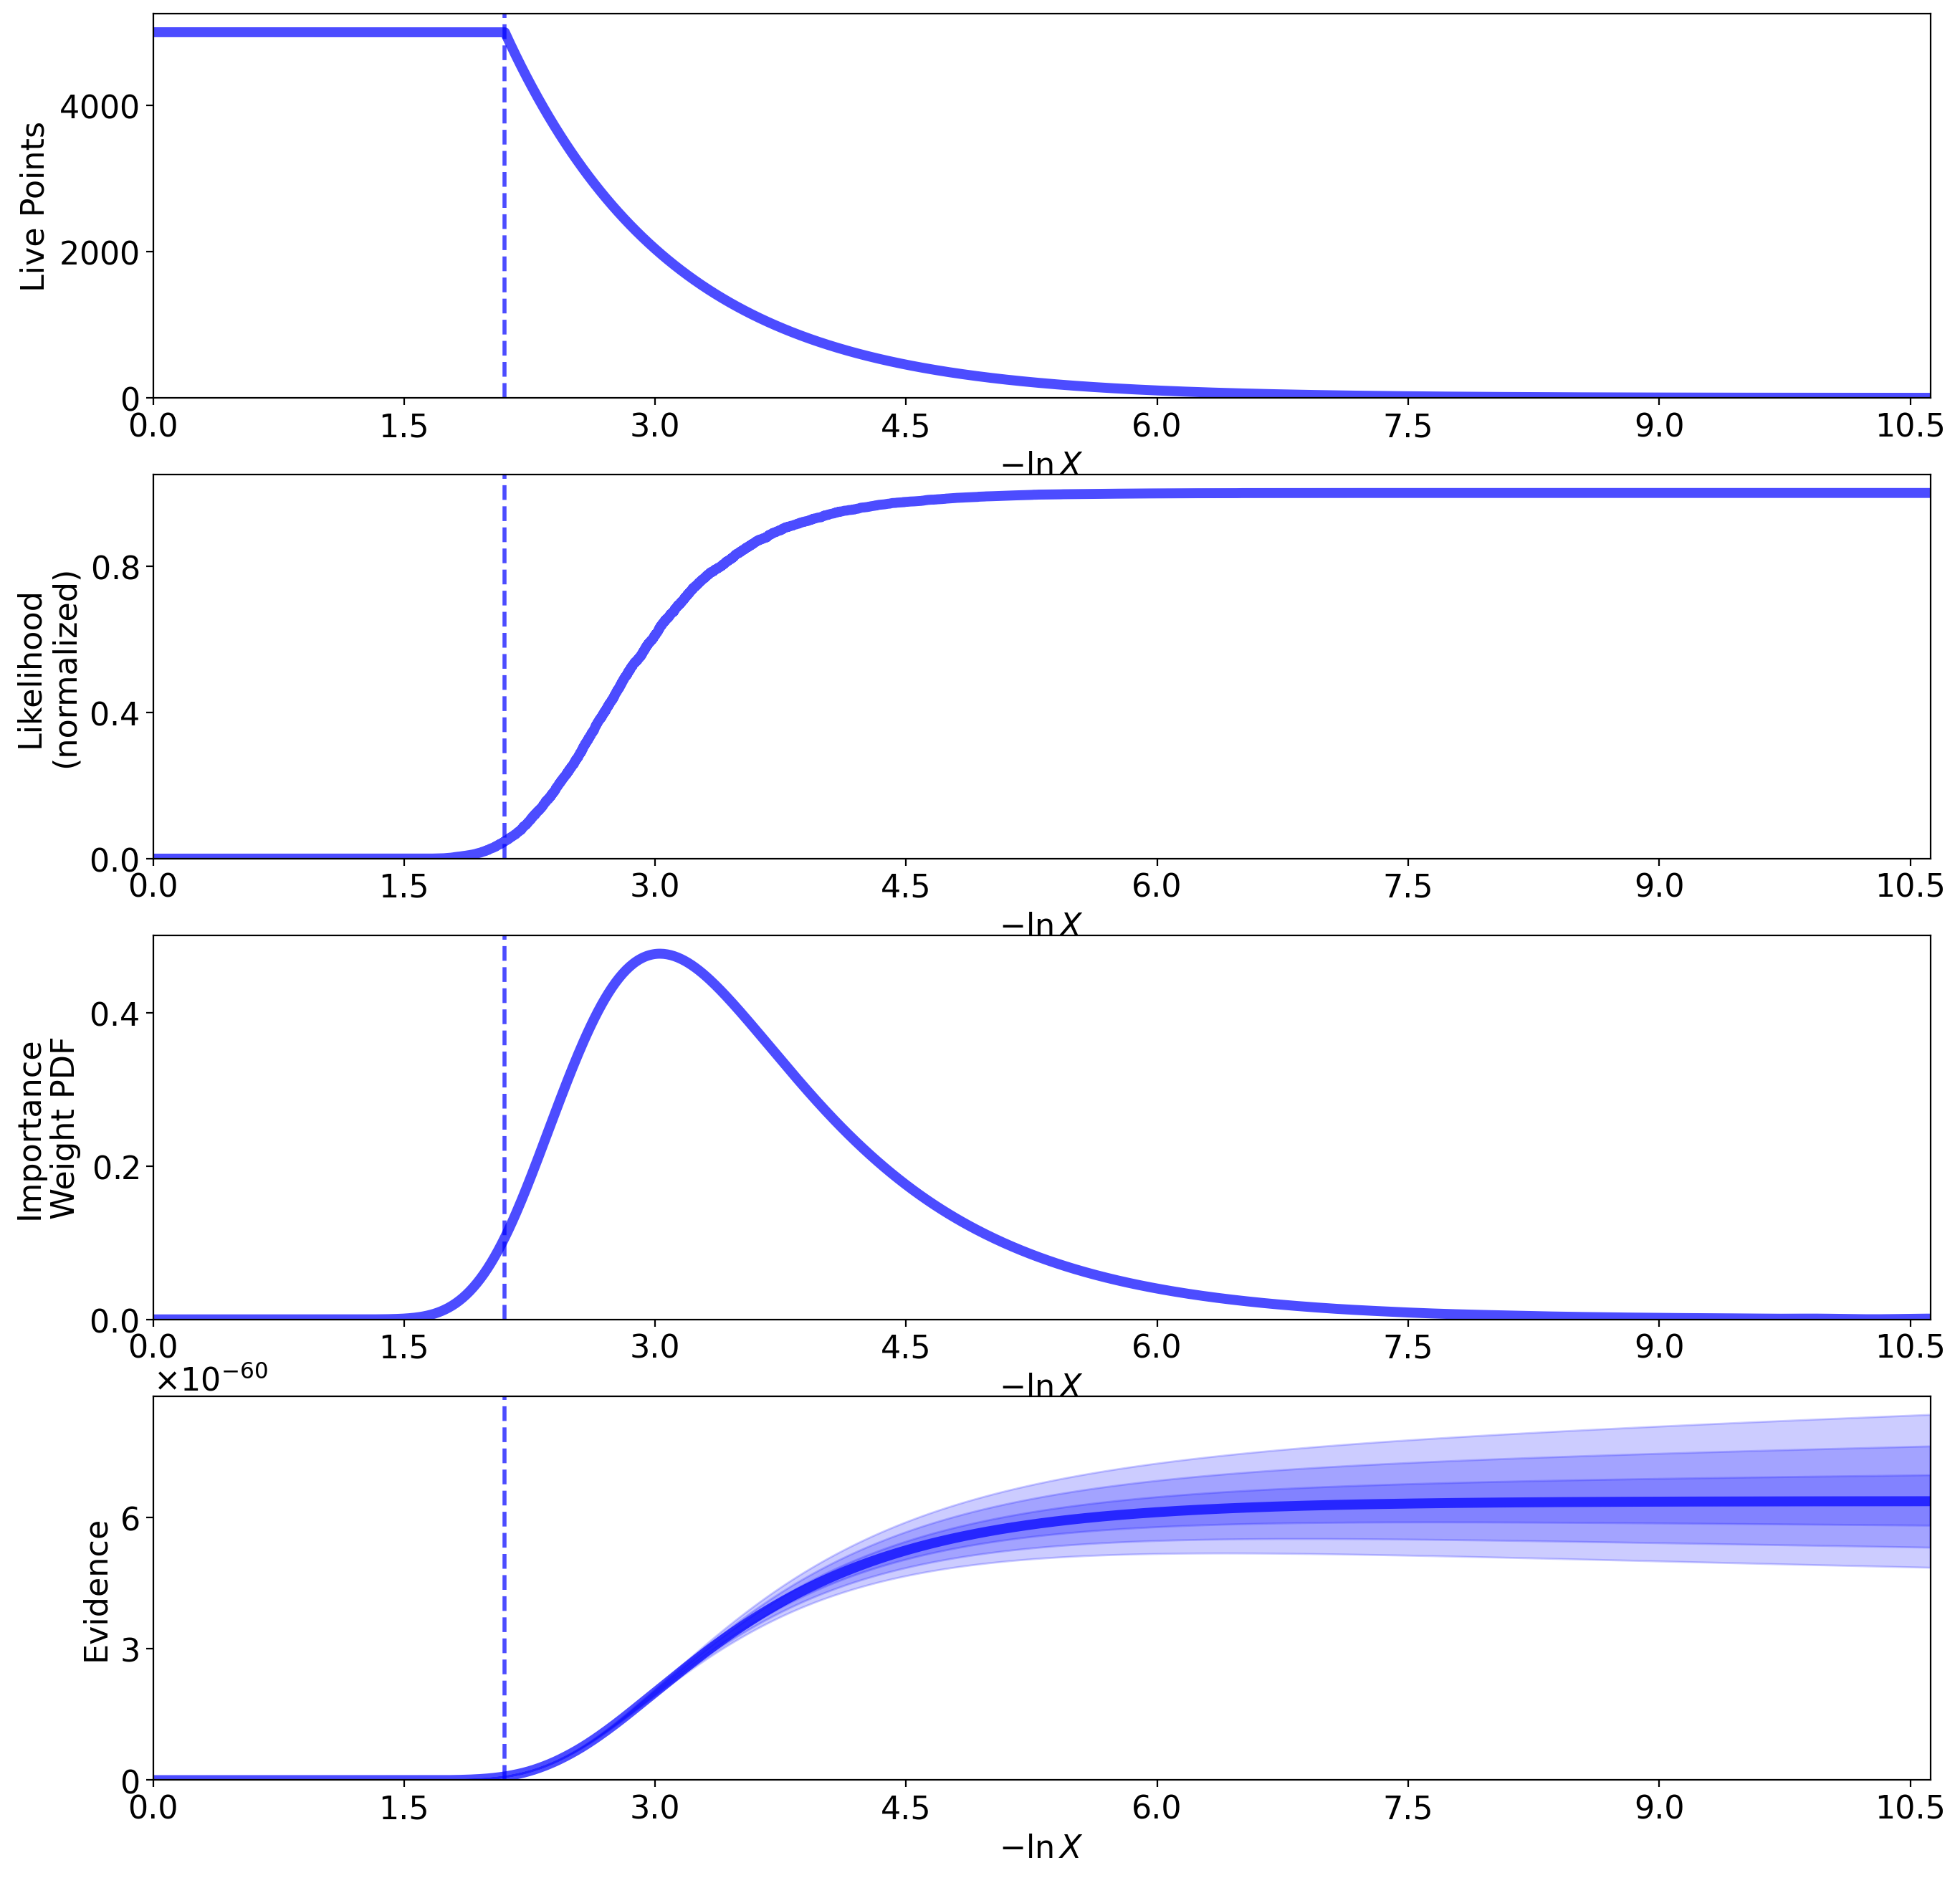

In [32]:
rfig, raxes = dyplot.runplot(sresults1)

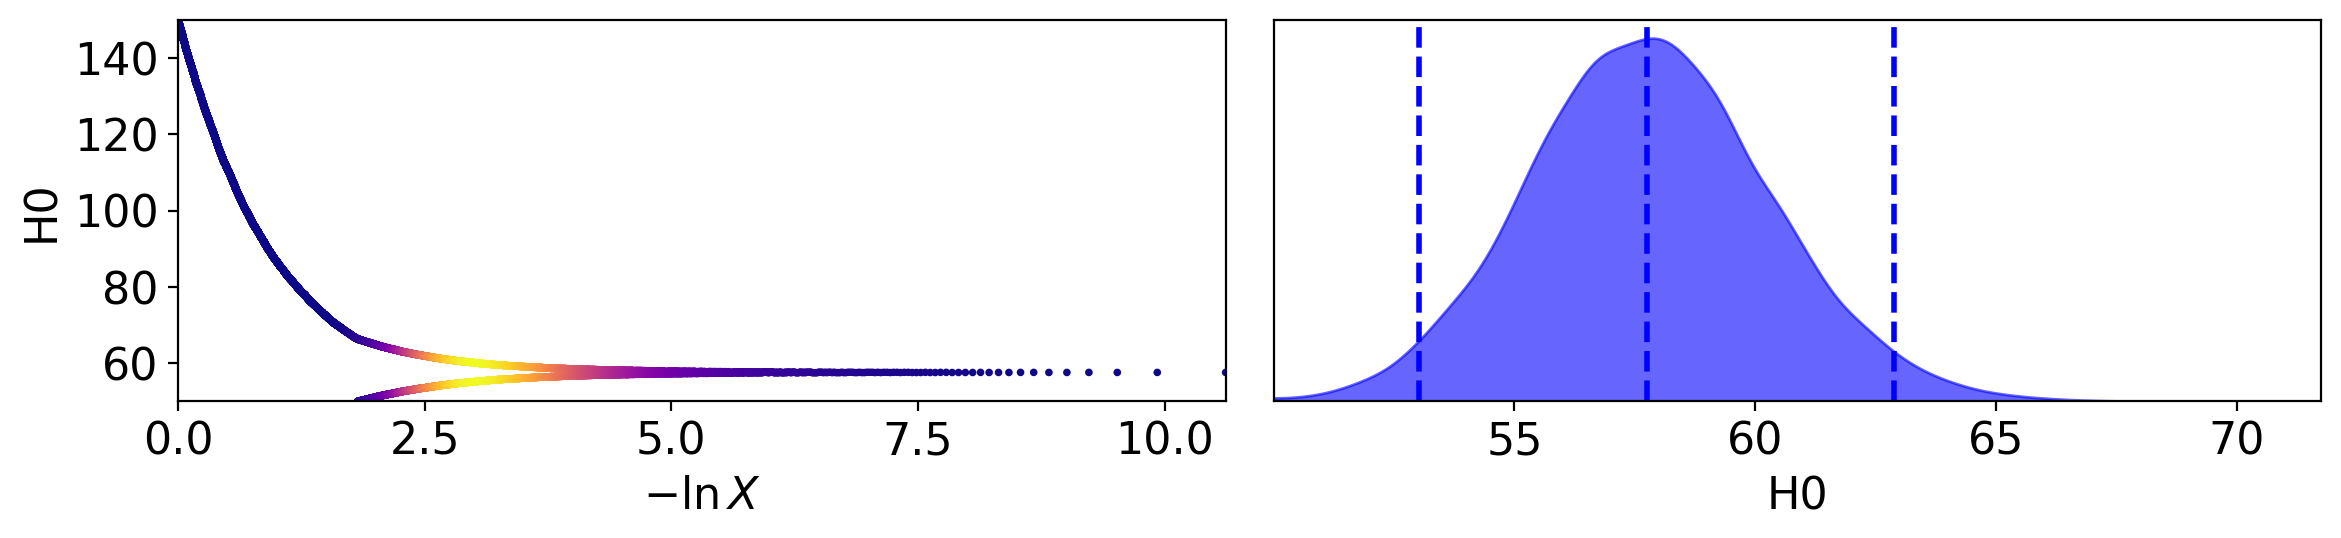

In [33]:
new_labels = ["H0"]
tfig, taxes = dyplot.traceplot(sresults1, labels=new_labels)
tfig.tight_layout()

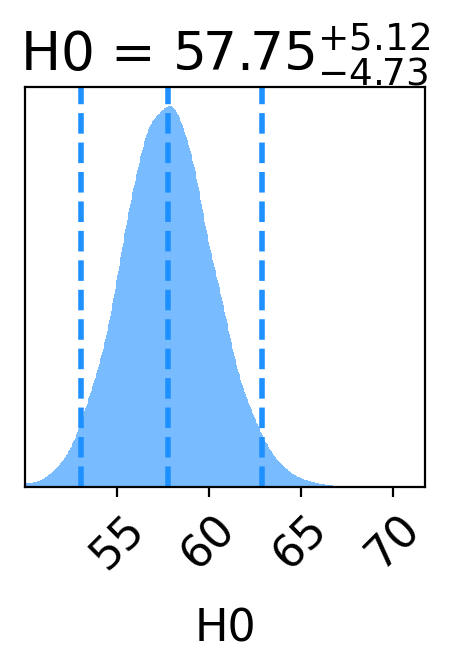

In [34]:
fg, ax = dyplot.cornerplot(sresults1, color='dodgerblue', #truths=np.zeros(ndim),
                           truth_color='black', show_titles=True, labels=new_labels)

In [35]:
weights1 = np.exp(sresults1['logwt'] - sresults1['logz'][-1])
postsamples1 = resample_equal(sresults1.samples, weights1)

In [36]:
print(sresults.summary(),sresults1.summary() )

Summary
nlive: 5000
niter: 9884
ncall: 36000
eff(%): 41.344
logz: -135.691 +/-  0.099
Summary
nlive: 5000
niter: 10511
ncall: 40792
eff(%): 38.025
logz: -136.304 +/-  0.090
None None


In [37]:
Bevidence = np.exp(np.median(sresults.logz))/np.exp(np.median(sresults1.logz))
Bevidence

297.0365395925166

In [38]:
chosen_post = int(stats.uniform.rvs(0, len(postsamples)))
H0_nest = postsamples[chosen_post][0]
om_nest = postsamples[chosen_post][1]
y_predictions_de = dist(X_grid,H0_nest, om_nest)

chosen_post0 = int(stats.uniform.rvs(0, len(postsamples1)))
H0_wode = postsamples1[chosen_post0][0]
om_wode = 1.0
y_predictions_wode = dist(X_grid,H0_wode, om_wode)

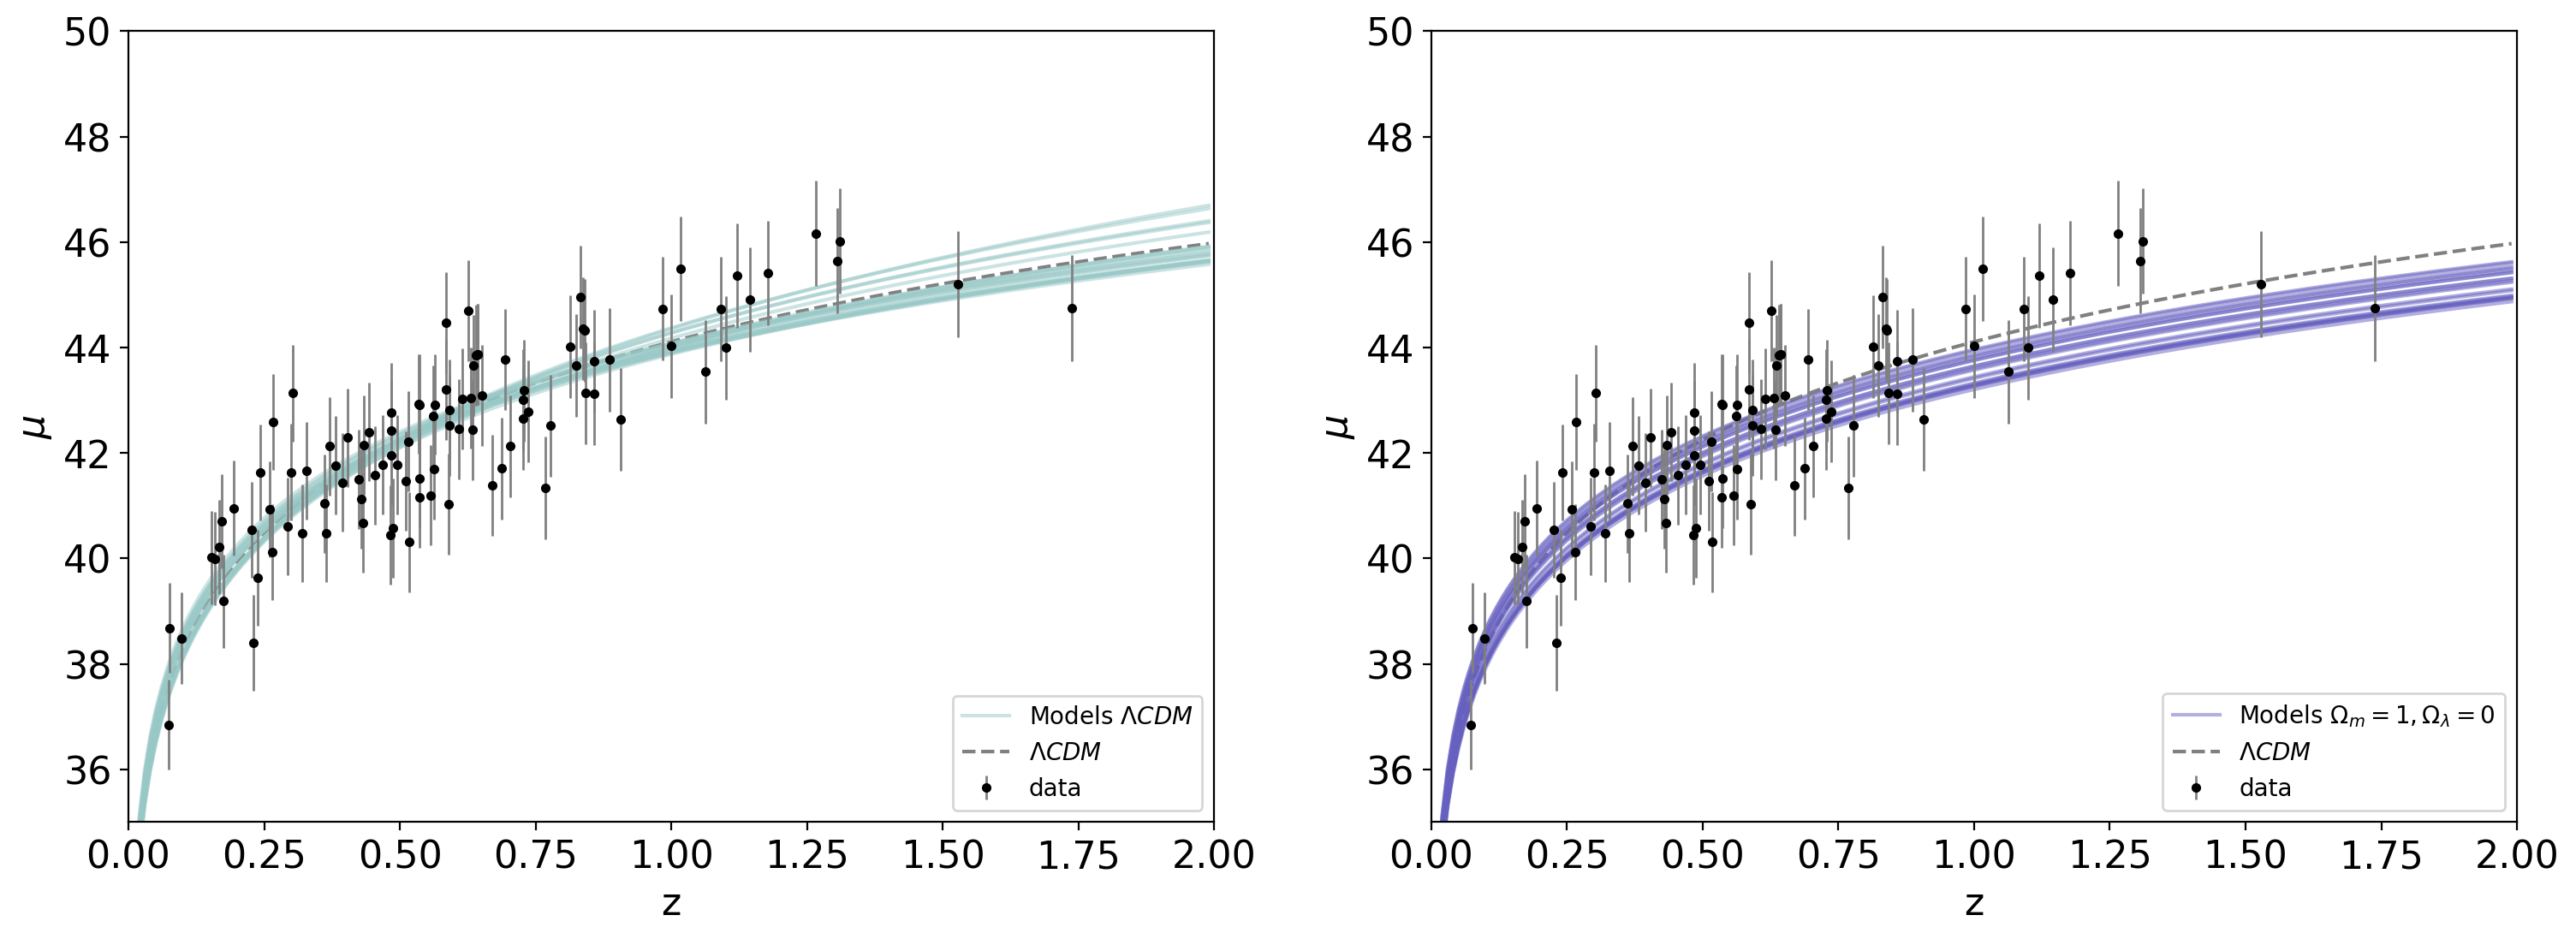

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(X_grid, y_predictions_de, c=colors[2], alpha=0.5, label='Models $\Lambda CDM$', zorder=0)
ax1.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=1)
ax1.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$',zorder=0)
ax1.set_xlabel("z")
ax1.set_ylabel("$\mu$")
ax1.legend(loc='lower right',fontsize=10)
ax1.set_xlim(0,2)
ax1.set_ylim(35,50)

ax2.plot(X_grid, y_predictions_wode, c=colors[4], alpha=0.5, label='Models $\Omega_m = 1,\Omega_{\lambda} = 0$', zorder=0)
ax2.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', mec='black', lw=1,label='data', zorder=1)
ax2.plot(X_grid, mu_true, c='gray',ls='dashed', label='$\Lambda CDM$',zorder=0)
ax2.set_xlabel("z")
ax2.set_ylabel("$\mu$")
ax2.legend(loc='lower right',fontsize=10)
ax2.set_xlim(0,2)
ax2.set_ylim(35,50)

for i in range(1, 20):
    
    chosen_post_2 = int(stats.uniform.rvs(0, len(postsamples)))
    H0_nest = postsamples[chosen_post_2][0]
    om_nest = postsamples[chosen_post_2][1]
    y_predictions_nest = dist(X_grid, H0_nest, om_nest)
    ax1.plot(X_grid, y_predictions_nest, c=colors[2], alpha=0.5, zorder=0)
    
    chosen_post1 = int(stats.uniform.rvs(0, len(postsamples1)))
    H0_nest1 = postsamples1[chosen_post1][0]
    y_predictions_nest1 = dist(X_grid, H0_nest, 1)
    ax2.plot(X_grid, y_predictions_nest1, c=colors[4], alpha=0.5, zorder=0)

plt.show()

## Mocking data

In [40]:
z_vals=np.random.uniform(0,2,1000)
mu_nested=[]
mu_gpr=[]

for z in z_vals:

    H0,Om = postsamples[int(stats.uniform.rvs(0, len(postsamples)))]
    mu_nested.append(dist(z,H0,Om))
    
    
    mu_fit, sigma = gp.predict([[z]], return_std=True)
    mu_gpr.append(np.random.normal(loc=mu_fit,scale=sigma))


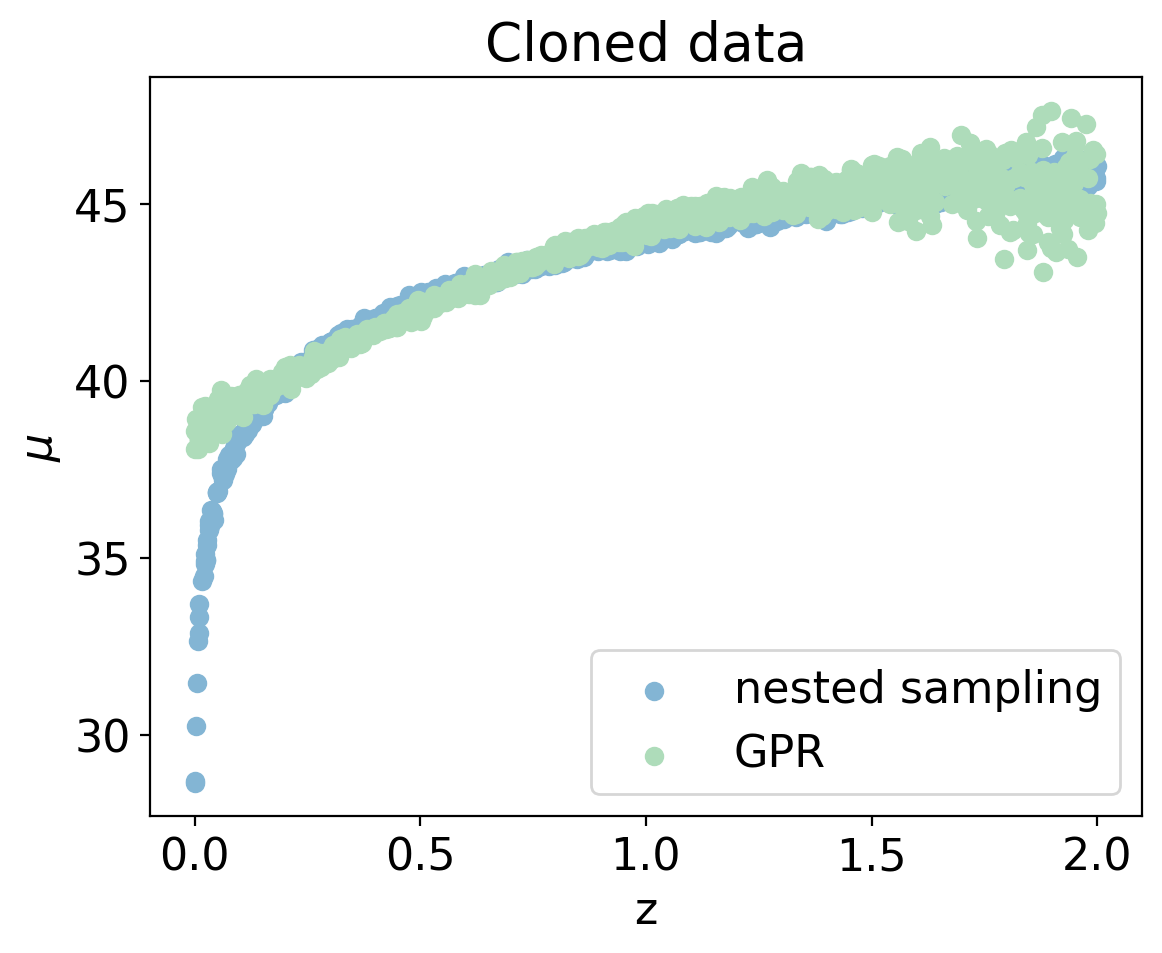

In [41]:
plt.scatter(z_vals,mu_nested,label="nested sampling", color=colors[3])
plt.scatter(z_vals,mu_gpr,label='GPR', color=colors[1])

plt.xlabel("z")
plt.ylabel("$\mu$")
#plt.xlim(0,2)
#plt.ylim(35,50)
plt.title("Cloned data")
plt.legend()
plt.show()

NB: blue points are theory-informed, while the green points are data-driven!